# Investor Risk Tolerance and Robo Advisor

The goal of this case study is to build a ML model to predict the risk tolerance or risk aversion of an investor, and use the model in a robo-advisor dashboard.

투자자의 위험 허용 범위는 포트폴리오 배분과 포트폴리오 관리 과정의 한 단계이고 포트폴리오 재조정에 중요한 요소이다. 
대부분의 접근방법은 질적 판단과 상당한 수작업.
대개의 경우, 위험 감수 설문을 통해 결정.
오류가 발생하기 쉽다. 
이유: 투자자의 행동적 편향. 투자자가 스스로 위험을 인지하기 어려움. 수기로 작성되기 때문에 자동화가 어려움.

머신러닝을 이용해 포트폴리오 관리 과정에서 수작업을 자동화
1. 투자자의 위험 허용 범위를 예측하는 지도 회귀 기반 모델을 구축
2. 로보 어드바이저 대시보드를 만들고 대시보드에서 위험 감수 예측 모델을 구현

주요 내용
* 특성 제거와 특성의 중요성/직관성
* 머신러닝을 사용한 포트폴리오 관리 과정 내 수작업을 자동화하기
* 머신러닝을 사용한 투자자 행동 편향을 수치화하고 모델링하기
* 머신러닝 모델을 파이썬을 이용해 대시보드에 탑재하기

## 1. Problem definition

Supervised regression framework 

Predicted variable: the “true” risk tolerance of an individual
Predictor variables: demographic, financial and behavioral attributes of an individual

For this case study the data used is from survey of Consumer Finances which is conducted by the Federal Reserve Board. 

The data source is : 
https://www.federalreserve.gov/econres/scf_2009p.htm

## 2. Load libraries and dataset

In [60]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import copy 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Libraries for Statistical Models
import statsmodels.api as sm

# Libraries for Saving the Model
from pickle import dump, load 

In [61]:
dataset = pd.read_csv('data/SCFP2009panel.csv')

In [62]:
dataset.shape

(19285, 515)

## 3. Data prepararion and feature selection

### 3.1 Preparing the predicted variable

The dataset from "Survey of Consumer Finances" contains the Household's demographics, net worth, financial and non-financial assets for the same demographics in 2007 (pre-crisis) and 2009(post-crisis). 

We prepare the predicted variable, which is the "true" risk tolerance in the following steps. 
There are different ways of getting the "true" risk tolerance. The idea and the purpose of this case study is to come up with an approach to solve the behavioral finance problem using machine learning. 

The steps to compute the predicted variables are as follows: 

1) Compute the risky asset and the riskless assets for all the individuals in the survey data.  
* **Risky assets**: investments in mutual funds, stocks, bonds, commodities, real estate and an estimate of human capital. 
* **Risk Free Assets**: checking and savings balances, certificates of deposit, other cash balances and equivalents.

2) We take the ratio of risky assets to total assets of an investor and consider that as a measure of risk tolerance of an investor. 
From the data of SCF, we have the data of risky and riskless assets for the individuals for 2007 and 2009. 
We use this data and normalise the risky assets with the stock price of 2007 vs. 2009 to get risk tolerance. 
* **Risk Tolerance**: the ratio of Risky Asset to Riskless Assets normalised with the average S&P500 of 2007 vs 2009. 
    * Average S&P500 in 2007: 1478
    * Average S&P500 in 2009: 948

3) In a lot of literature, an intelligent investor is the one who doesn't change its risk tolerance during the change in the market. 
So, we consider the investors who change their risk tolerance by less than 10% between 2007 and 2009 as the intelligent investors. 

In [63]:
# Average SP500 during 2007 and 2009
Average_SP500_2007 = 1478
Average_SP500_2009 = 948

# Risk tolerance 2007
dataset['RiskFree07'] = dataset['LIQ07'] + dataset['CDS07'] + dataset['SAVBND07'] + dataset['CASHLI07']
dataset['Risky07'] = dataset['NMMF07'] + dataset['STOCKS07'] + dataset['BOND07'] 
dataset['RT07'] = dataset['Risky07'] / (dataset['Risky07']+dataset['RiskFree07'])

#Risk Tolerance 2009
dataset['RiskFree09'] = dataset['LIQ09'] + dataset['CDS09'] + dataset['SAVBND09'] + dataset['CASHLI09']
dataset['Risky09'] = dataset['NMMF09'] + dataset['STOCKS09'] + dataset['BOND09'] 
dataset['RT09'] = dataset['Risky09'] / (dataset['Risky09']+dataset['RiskFree09']) * (Average_SP500_2009/Average_SP500_2007)

In [64]:
dataset2 = copy.deepcopy(dataset)
dataset.head()

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I,RiskFree07,Risky07,RT07,RiskFree09,Risky09,RT09
0,1,11,11668.13420,47,3,12,2,1,0,2,...,0.0,93.125197,270.403054,57,7994.813847,0.0,0.0,16000,17000,0.330422
1,1,12,11823.45649,47,3,12,2,1,0,2,...,0.0,93.125197,249.593620,57,7994.813847,0.0,0.0,19000,18000,0.312036
2,1,13,11913.22835,47,3,12,2,1,0,2,...,0.0,93.125197,209.233358,57,7984.457871,0.0,0.0,13000,12000,0.307876
3,1,14,11929.39427,47,3,12,2,1,0,2,...,0.0,93.125197,209.273158,57,7984.457871,0.0,0.0,25000,13000,0.219429
4,1,15,11917.72291,47,3,12,2,1,0,2,...,0.0,93.125197,232.690767,57,7994.813847,0.0,0.0,17000,12000,0.265410


In [65]:
dataset2['PercentageChange'] = np.abs(dataset2['RT09']/dataset2['RT07'] - 1)

In [66]:
#dataset2.isnull().values.any()
dataset2.isnull().sum().sum()

11949

In [67]:
dataset2 = dataset2.dropna(axis=0)
dataset2 = dataset2[~dataset2.isin([np.nan, np.inf, -np.inf]).any(1)]

dataset2.isnull().sum().sum()

0

<AxesSubplot:xlabel='RT07'>

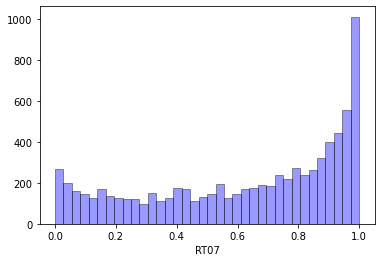

In [80]:
sns.distplot(dataset2['RT07'], hist=True, kde=False, bins=int(180/5), color='blue', hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='RT09'>

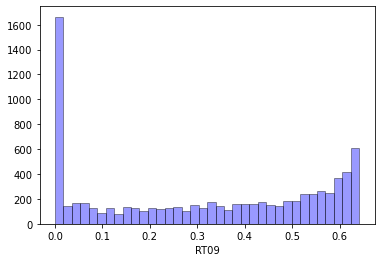

In [86]:
sns.distplot(dataset2['RT09'], hist=True, kde=False, bins=int(180/5), color='blue', hist_kws={'edgecolor':'black'})

Looking at the risk tolerance of 2007, we see that a significant number of individuals had risk tolerance close to one.
Meaning the investment was more skewed towards the risky assets as compared to the riskless assets. 

Now let us look at the risk tolerance of 2009.
Clearly, the behavior of the individuals reversed in 2009 after crisis and majority of the investment was in risk free assets. 
Overall risk tolerance decreased, which is shown by majority of risk tolerance being close to 0 in 2009. 
In the next step we pick the intelligent investors whose risk tolerance change between 2007 and 2009 was less than 10%.

In [87]:
dataset3 = copy.deepcopy(dataset2)
dataset3 = dataset3[dataset3['PercentageChange']<=.1]

In [88]:
dataset3['TrueRiskTolerance'] = (dataset3['RT07'] + dataset3['RT09']) / 2

In [89]:
dataset3.drop(labels=['RT07', 'RT09'], axis=1, inplace=True)
dataset3.drop(labels=['PercentageChange'], axis=1, inplace=True)

### 3.2 Feature selection - Limit the feature space

#### 3.2.2 Features elimination

In order to filter the features further we do the following:
1. Check the description in the Data Dictionary (https://www.federalreserve.gov/econres/files/codebk2009p.txt, https://www.federalreserve.gov/econresdata/scf/files/fedstables.macro.txt) and only keep the features that are intuitive. 
The description is as follows: 
* AGE: There are 6 age categories, where 1 represents age less than 35 and 6 represents age more than 75.
* EDUC: There are 4 education categories, where 1 represents no high school and 4 represents college degree.
* MARRIED: It represents marital status. There are two categories where 1 represents married and 2 represents unmarried. 
* OCCU: It represents occupation category. 1 represents managerial category and 4 represents unemployed.
* KIDS: It represents number of kids. 
* NWCAT: It represents net worth category. There are 5 categories, where 1 net worth less than 25 percentile and 5 represents net worth more than 90th percentile. 
* INCCL: It represents income category. There are 5 categories, where 1 income less than 10,000 and 5 represents net worth more than 100,000.
* RISK: It represents the willingness to take risk on a scale of 1 to 4, where 1 represents highest level of willingness to take risk. 

2. Keep only the intuitive factors as of 2007 only and remove all the intermediate features and features related to 2009, as the variables of 2007 are the only ones required for predicting the risk tolerance.

In [91]:
keep_list2 = ['AGE07','EDCL07','MARRIED07','KIDS07','OCCAT107','INCOME07','RISK07','NETWORTH07','TrueRiskTolerance']
drop_list2 = [col for col in dataset3.columns if col not in keep_list2]

dataset3.drop(labels=drop_list2, axis=1, inplace=True)

<AxesSubplot:title={'center':'Correlation matrix'}>

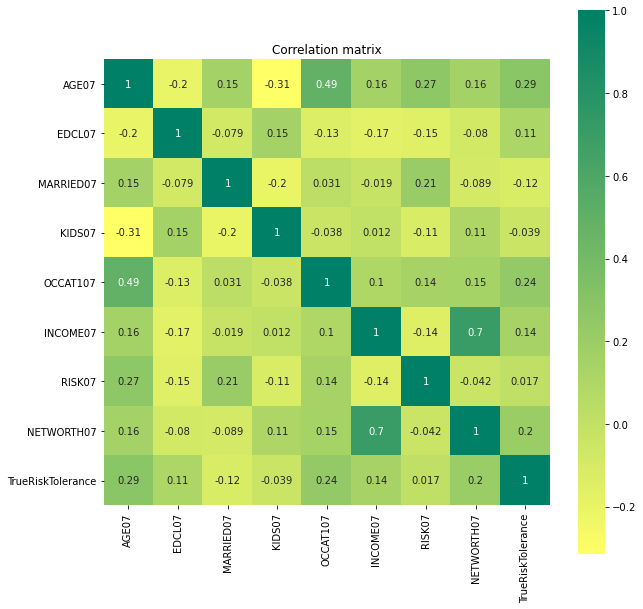

In [106]:
# Correlation
correlation = dataset3.corr()
plt.figure(figsize=(10,10))
plt.title('Correlation matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='summer_r')

<Figure size 1080x1080 with 0 Axes>

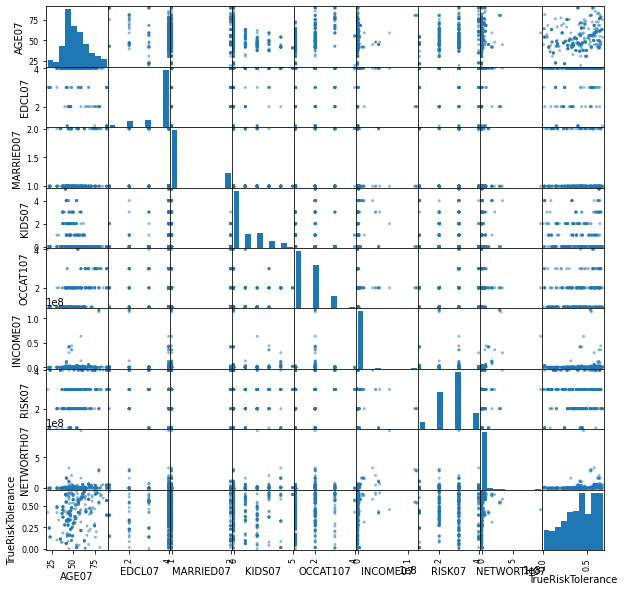

In [108]:
# Scatterplot matrix
from pandas.plotting import scatter_matrix
plt.figure(figsize=(15,15))
scatter_matrix(dataset3, figsize=(10,10))
plt.show()

Looking at the correlation chart above, networth and income are positively correlated with the risk tolerance. 
With more number of kids and marriage the risk tolerance decreases. 
As the willingness to take risk decreases the risk tolerance decreases. 
With age there is a positive relationship of the risk tolerance.

As per the paper "Does Risk Tolerance Decrease With Age? (Hui Wang1,Sherman Hanna)", Relative risk aversion decreases as people age (i.e., the proportion of net wealth invested in risky assets increases as people age) when other variables are held constant.
Therefore, risk tolerance increases with age.

So, in summary all the variables and their relationship with risk tolerance seems intuitive.

## 4. Evaluate algorithms and models

In [110]:
# Train-test split
Y = dataset3['TrueRiskTolerance']
X = dataset3.loc[:, dataset3.columns != 'TrueRiskTolerance']

validation_size = 0.2
seed = 3

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [114]:
# Test options and evaluation metrics
num_folds = 10
scoring = 'r2'

In [112]:
# Regression models
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

# Neural Network
#models.append(('MLP', MLPRegressor()))

# Ensable Models - Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

# Ensable Models - Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [115]:
# K-folds cross validation
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    # Convert mean square error to positive. The lower the better.
    cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.102704 (0.179297)
LASSO: -0.041555 (0.109033)
EN: -0.047729 (0.108990)
KNN: -0.424567 (0.141427)
CART: -0.547348 (0.162024)
SVR: -0.127780 (0.100826)
ABR: -0.382644 (0.146197)
GBR: -0.621957 (0.140963)
RFR: -0.704107 (0.113417)
ETR: -0.703782 (0.138033)


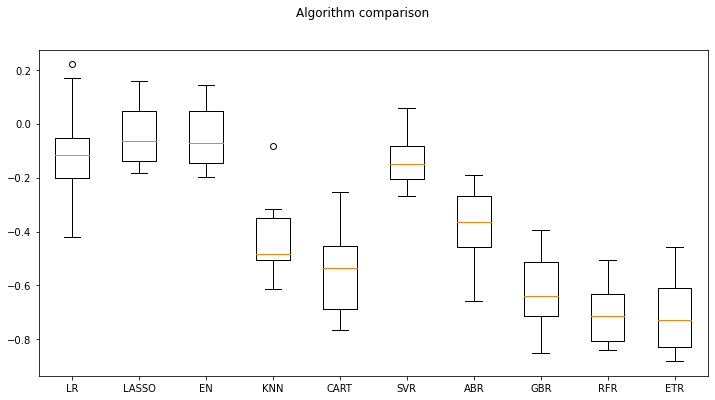

In [120]:
# Compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(12,6)
plt.show()

The non linear models perform better than the linear models, which means that a non linear relationship between the risk tolerance and the difference variables use to predict it. 
Given random forest regression is one of the best methods, we use it for further grid search.

## 5. Model tuning and grid search

In [134]:
# Grid search: RandomForestRegressor
'''
n_estimators: integer, optional (default=10)
    The number of trees in the forest.
'''
param_grid = {'n_estimators': list(range(50,400,50))}
# param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.712818 using {'n_estimators': 300}
0.704419 (0.103305) with: {'n_estimators': 50}
0.704148 (0.121454) with: {'n_estimators': 100}
0.709408 (0.101490) with: {'n_estimators': 150}
0.712431 (0.109419) with: {'n_estimators': 200}
0.709149 (0.098823) with: {'n_estimators': 250}
0.712818 (0.098430) with: {'n_estimators': 300}
0.709108 (0.100915) with: {'n_estimators': 350}


In [135]:
best_n_estimators = grid_result.best_params_['n_estimators']

## 6. Finalise the model

### 6.1 Resilts on the test dataset

In [136]:
# Prepare model
model = RandomForestRegressor(n_estimators=best_n_estimators)
model.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=300)

In [137]:
from sklearn.metrics import r2_score
predictions_train = model.predict(X_train)
print(r2_score(Y_train, predictions_train))

0.9636049564084136


In [139]:
# Estimate accurracy on validation set
from sklearn.metrics import mean_squared_error
predictions = model.predict(X_validation)
print(mean_squared_error(Y_validation, predictions))
print(r2_score(Y_validation, predictions))

0.007637736132790717
0.765866952850168


### 6.2 Feature importance and feature intuition

Looking at the details above Random forest be worthy of further study. 
Let us look into the Feature Importance of the RF model

In [140]:
model = RandomForestRegressor(n_estimators=best_n_estimators, n_jobs=-1)
model.fit(X_train, Y_train)
print(model.feature_importances_)

[0.23535078 0.0229664  0.01396365 0.04350557 0.02469472 0.23852147
 0.05455226 0.36644514]


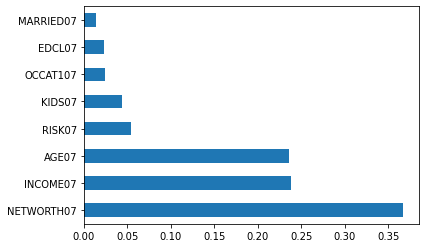

In [147]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

From the chart above, income and networth followed by age and willingness to take risk are the key variables to decide the risk tolerance. 
These variables have been considered as the key variables to model the risk tolerance across several literature.

### 6.3 Save the model for later use

In [148]:
filename = 'ch5_3_finalised_model.sav'
dump(model, open(filename, 'wb'))

In [149]:
# # load the model from disk
# loaded_model = load(open(filename, 'rb'))
# # estimate accuracy on validation set
# predictions = loaded_model.predict(X_validation)
# result = mean_squared_error(Y_validation, predictions)
# print(r2_score(Y_validation, predictions))
# print(result)

0.772143435543002
0.007432988792620424


**Conclusion**:

We showed that machine learning models might be able to objectively analyze the behavior of different investors in a changing market and attribute these changes to variables involved in determining risk appetite. 
With an increase in the volume of investor’s data and availability of rich machine learning infrastructure, such models might prove to be more useful.

We saw that there is a non-linear relationship between the variables and the risk tolerance. 
Income and net worth followed by age and willingness to take risk are the key variables to decide the risk tolerance. 
These variables have been considered as the key variables to model the risk tolerance across several literature.
